# Project 2: Supervised Learning
### Building a Student Intervention System

## 1. Classification vs Regression

Your goal is to identify students who might need early intervention - which type of supervised machine learning problem is this, classification or regression? Why?

##### This is a classification problem becasuse we are trying to predict if student will drop out or not based on avialble data

## 2. Exploring the Data

Let's go ahead and read in the student dataset first.

_To execute a code cell, click inside it and press **Shift+Enter**._

In [34]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
%matplotlib inline 

In [2]:
# Read student data
student_data = pd.read_csv("student-data.csv")
print "Student data read successfully!"
# Note: The last column 'passed' is the target/label, all other are feature columns

Student data read successfully!



Now, can you find out the following facts about the dataset?
- Total number of students
- Number of students who passed
- Number of students who failed
- Graduation rate of the class (%age)
- Number of features

_Use the code block below to compute these values. Instructions/steps are marked using **TODO**s._

In [138]:


# TODO: Compute desired values - replace each '?' with an appropriate expression/function call
n_students = student_data.shape[0]
n_features = student_data.shape[1] - 1 
n_passed = len(student_data[student_data.passed == "yes"])
n_failed = len(student_data[student_data.passed == "no"])
grad_rate = float(n_passed) / n_students * 100 
print "Total number of students: {}".format(n_students)
print "Number of students who passed: {}".format(n_passed)
print "Number of students who failed: {}".format(n_failed)
print "Number of features: {}".format(n_features)
print "Graduation rate of the class: {:.2f}%".format(grad_rate)

Total number of students: 395
Number of students who passed: 265
Number of students who failed: 130
Number of features: 30
Graduation rate of the class: 67.09%


## 3. Preparing the Data
In this section, we will prepare the data for modeling, training and testing.

### Identify feature and target columns
It is often the case that the data you obtain contains non-numeric features. This can be a problem, as most machine learning algorithms expect numeric data to perform computations with.

Let's first separate our data into feature and target columns, and see if any features are non-numeric.<br/>
**Note**: For this dataset, the last column (`'passed'`) is the target or label we are trying to predict.

In [4]:
# Extract feature (X) and target (y) columns
feature_cols = list(student_data.columns[:-1])  # all columns but last are features
target_col = student_data.columns[-1]  # last column is the target/label
print "Feature column(s):-\n{}".format(feature_cols)
print "Target column: {}".format(target_col)

X_all = student_data[feature_cols]  # feature values for all students
y_all = student_data[target_col]  # corresponding targets/labels
print "\nFeature values:-"
X_all.head()  # print the first 5 rows

Feature column(s):-
['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']
Target column: passed

Feature values:-
  school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  \
0     GP   F   18       U     GT3       A     4     4  at_home   teacher   
1     GP   F   17       U     GT3       T     1     1  at_home     other   
2     GP   F   15       U     LE3       T     1     1  at_home     other   
3     GP   F   15       U     GT3       T     4     2   health  services   
4     GP   F   16       U     GT3       T     3     3    other     other   

    ...    higher internet  romantic  famrel  freetime goout Dalc Walc health  \
0   ...       yes       no        no       4         3     4    1    1      3   
1   ...    

### Preprocess feature columns

As you can see, there are several non-numeric columns that need to be converted! Many of them are simply `yes`/`no`, e.g. `internet`. These can be reasonably converted into `1`/`0` (binary) values.

Other columns, like `Mjob` and `Fjob`, have more than two values, and are known as _categorical variables_. The recommended way to handle such a column is to create as many columns as possible values (e.g. `Fjob_teacher`, `Fjob_other`, `Fjob_services`, etc.), and assign a `1` to one of them and `0` to all others.

These generated columns are sometimes called _dummy variables_, and we will use the [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) function to perform this transformation.

In [5]:
# Preprocess feature columns
def preprocess_features(X):
    outX = pd.DataFrame(index=X.index)  # output dataframe, initially empty

    # Check each column
    for col, col_data in X.iteritems():
        # If data type is non-numeric, try to replace all yes/no values with 1/0
        if col_data.dtype == object:
            col_data = col_data.replace(['yes', 'no'], [1, 0])
        # Note: This should change the data type for yes/no columns to int

        # If still non-numeric, convert to one or more dummy variables
        if col_data.dtype == object:
            col_data = pd.get_dummies(col_data, prefix=col)  # e.g. 'school' => 'school_GP', 'school_MS'

        outX = outX.join(col_data)  # collect column(s) in output dataframe

    return outX

X_all = preprocess_features(X_all)
print "Processed feature columns ({}):-\n{}".format(len(X_all.columns), list(X_all.columns))

Processed feature columns (48):-
['school_GP', 'school_MS', 'sex_F', 'sex_M', 'age', 'address_R', 'address_U', 'famsize_GT3', 'famsize_LE3', 'Pstatus_A', 'Pstatus_T', 'Medu', 'Fedu', 'Mjob_at_home', 'Mjob_health', 'Mjob_other', 'Mjob_services', 'Mjob_teacher', 'Fjob_at_home', 'Fjob_health', 'Fjob_other', 'Fjob_services', 'Fjob_teacher', 'reason_course', 'reason_home', 'reason_other', 'reason_reputation', 'guardian_father', 'guardian_mother', 'guardian_other', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']


### Split data into training and test sets

So far, we have converted all _categorical_ features into numeric values. In this next step, we split the data (both features and corresponding labels) into training and test sets.

In [124]:
from sklearn.cross_validation import train_test_split
# First, decide how many training vs test samples you want
num_all = student_data.shape[0]  # same as len(student_data)
num_train = 300  # about 75% of the data
num_test = num_all - num_train


# TODO: Then, select features (X) and corresponding labels (y) for the training and test sets
# Note: Shuffle the data or randomly select samples to avoid any bias due to ordering in the dataset
# I am using treain_test_split which  wraps input validation and next(iter(ShuffleSplit(n_samples))) and application to input data into a single call for splitting (and optionally subsampling) data in a oneliner.


X_train , X_test,  y_train , y_test = train_test_split(X_all, y_all, test_size = num_test, random_state=0 )

print "Training set: {} samples".format(X_train.shape[0])
print "Test set: {} samples".format(X_test.shape[0])
# Note: If you need a validation set, extract it from within training data

Training set: 300 samples
Test set: 95 samples


In [48]:
def learning_curve_graph(sizes, train_err, test_err):
    '''Plot training and test error as a function of the training size.'''

    pl.figure()
    pl.title('Performance vs Training Size')
    pl.plot(sizes, test_err, lw=2, label = 'test error' )
    pl.plot(sizes, train_err, lw=2, label = 'training error')
    #pl.ylim (0,1)
    pl.legend(loc='best')
    pl.xlabel('Training Size')
    pl.ylabel('Error')
    pl.show()

In [38]:
# Train a model
import time

def train_classifier(clf, X_train, y_train):
    print "Training {}...".format(clf.__class__.__name__)
    start = time.time()
    clf.fit(X_train, y_train)
    end = time.time()
    print "Done!\nTraining time (secs): {:.3f}".format(end - start)



array([   1.        ,   92.66666667,  184.33333333,  276.        ])

### Choosing Claisfier

In order to choose a clasifer for this problem I used the map of Sklearn classifiers. I test each clasifier to see accurencie. 

In [79]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import numpy as np

np.random.seed(123)

clf1 = DecisionTreeClassifier(max_depth=4)
clf2 = KNeighborsClassifier(n_neighbors=7)
clf3 = SVC(kernel='rbf', probability=True)

print('5-fold cross validation:\n')

for clf, label in zip([clf1, clf2, clf3], ['DecisionTreeClassifier', 'KNeighborsClassifier', 'SVC']):

    scores = cross_validation.cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

5-fold cross validation:

Accuracy: 0.69 (+/- 0.04) [DecisionTreeClassifier]
Accuracy: 0.69 (+/- 0.05) [KNeighborsClassifier]
Accuracy: 0.70 (+/- 0.03) [SVC]


####  Questions about 
- What is both the theoretical space complexity to represent the model and the time for the algorithm to make a prediction? 
You can either provide the big-O notation, or list several the of major features that may affect the algorithm and state if the largest driving factor is constant, linear, logrithmic, polynomical, etc in nature. 
<p> <b> 
Due to small dataset the prediction and training  times of the model are negleble.
Driving factor of comuputionn is liner in nature, meaning is we increase number of samples, the time it will take to execute will increase. As such driving factor is Liner.
https://en.wikipedia.org/wiki/Time_complexity#Polynomial_time
</b>
<p>
- What are the general applications of this model?
<p><b> Decision Tree Classifier applies a straitforward idea to solve the classification problem. it poses a series of carefully crafted questions about the attributes of the test record. Each time time it receive an answer, a follow-up question is asked until a conclusion about the calss label of the record is reached.</b>
</p>
- What are its strengths and weaknesses? 
<p><B>Advantages: Decision trees are simple to use, easy to understand.  <br>
Disadvantages:  Even a small change in input data can at times, cause large changes in the tree. <br>
Decision trees are also prone to errors in classification, owing to differences in perceptions and the limitations of applying statistical tools.</p> </b> <br>
<p>
- Given what you know about the data so far, why did you choose this model to apply?  <br><B>Predictive Power, Relative Simplicity<b> <p>

### Tuning 
After obtaining accurecny of each model, I will use grid search to search parameter space to find the best parmeters.


In [82]:
clf = DecisionTreeClassifier()
parameters = {'max_depth':[1, 10]}

from sklearn.grid_search import GridSearchCV 

reg = GridSearchCV(clf, param_grid = parameters,  verbose = 0)
print reg.fit(X_all, y_all)

print " Best regressor params:",  reg.best_params_

GridSearchCV(cv=None, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            random_state=None, splitter='best'),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid={'max_depth': [1, 10]}, pre_dispatch='2*n_jobs',
       refit=True, score_func=None, scoring=None, verbose=0)
 Best regressor params: {'max_depth': 1}


### Decision Tree Classifier Model
After obraining best parmeter, use it to perform clasification

Decision Tree Classifier Model 
------------------------------------------
Training set size: 100
Training DecisionTreeClassifier...
Done!
Training time (secs): 0.000
Predicting labels using DecisionTreeClassifier...
Done!
Prediction time (secs): 0.000
F1 score for training set: 0.805755395683
Predicting labels using DecisionTreeClassifier...
Done!
Prediction time (secs): 0.000
F1 score for test set: 0.802919708029
------------------------------------------
Training set size: 200
Training DecisionTreeClassifier...
Done!
Training time (secs): 0.000
Predicting labels using DecisionTreeClassifier...
Done!
Prediction time (secs): 0.000
F1 score for training set: 0.812720848057
Predicting labels using DecisionTreeClassifier...
Done!
Prediction time (secs): 0.000
F1 score for test set: 0.802919708029
------------------------------------------
Training set size: 300
Training DecisionTreeClassifier...
Done!
Training time (secs): 0.001
Predicting labels using DecisionTreeClassifier...
Done!
Pre

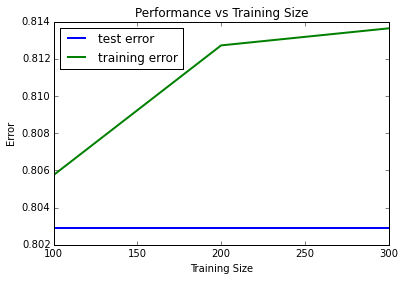

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            random_state=None, splitter='best')


In [132]:
print 'Decision Tree Classifier Model '

from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(max_depth =1)

sizes = np.linspace(len(X_train) / 3, len(X_train), 3)
train_err = np.zeros(len(sizes))
test_err = np.zeros(len(sizes))

for i, s in enumerate(sizes):
    s = s.astype(int)
    start = time.time()
    
    print "Done!\nTraining time (secs): {:.3f}".format(end - start)
    # Create and fit the decision tree regressor model
    clf.fit(X_train[:s], y_train[:s])
    train_t = time.time()
    train_predict(clf, X_train[:s], y_train[:s], X_test, y_test)
    # Find the performance on the training and testing set
    train_err[i] = f1_score  (y_train[:s], clf.predict(X_train[:s]) , pos_label='yes')
    train_time[i] = train_t - start
    test_err[i] = f1_score ( y_test, clf.predict(X_test) , pos_label='yes')

    predict_t= time.time()
    test_time[i] = 


# Plot learning curve graph
learning_curve_graph(sizes, train_err, test_err)

# end of copy

# Fit model to training data
#train_classifier(clf, X_train, y_train)  # note: using entire training set here
print clf  # you can inspect the learned model by printing it

### LinearSVC Classifier Model


In [90]:
clf = svm.LinearSVC(random_state=0)
parameters = {'C':[1, 10] }

from sklearn.grid_search import GridSearchCV 
reg = GridSearchCV(clf, param_grid = parameters,  verbose = 0)
print reg.fit(X_all, y_all)

print " Best regressor params:",  reg.best_params_

GridSearchCV(cv=None, error_score='raise',
       estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=0, tol=0.0001,
     verbose=0),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid={'C': [1, 10]}, pre_dispatch='2*n_jobs', refit=True,
       score_func=None, scoring=None, verbose=0)
 Best regressor params: {'C': 1}


LinearSVC Model training
------------------------------------------
Training set size: 100
Training LinearSVC...
Done!
Training time (secs): 0.007
Predicting labels using LinearSVC...
Done!
Prediction time (secs): 0.000
F1 score for training set: 0.874074074074
Predicting labels using LinearSVC...
Done!
Prediction time (secs): 0.000
F1 score for test set: 0.724409448819
------------------------------------------
Training set size: 200
Training LinearSVC...
Done!
Training time (secs): 0.018
Predicting labels using LinearSVC...
Done!
Prediction time (secs): 0.000
F1 score for training set: 0.825174825175
Predicting labels using LinearSVC...
Done!
Prediction time (secs): 0.000
F1 score for test set: 0.782608695652
------------------------------------------
Training set size: 300
Training LinearSVC...
Done!
Training time (secs): 0.024
Predicting labels using LinearSVC...
Done!
Prediction time (secs): 0.000
F1 score for training set: 0.841379310345
Predicting labels using LinearSVC...
Done!

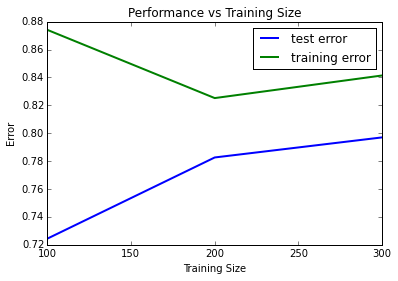

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=0, tol=0.0001,
     verbose=0)


In [126]:
print 'LinearSVC Model training'
# TODO: Choose a model, import it and instantiate an object
# Linear SVC .LinearSVC
#KN Neibers 
#SVC Ensable Classification 
# We will vary the training set size so that we have 50 different sizes
#start of copy  
from sklearn import svm
#parameters from grid search came out as default. No need to tune
clf = svm.LinearSVC(random_state=0)

sizes = np.linspace(len(X_train) / 3, len(X_train), 3)
train_err = np.zeros(len(sizes))
test_err = np.zeros(len(sizes))

for i, s in enumerate(sizes):
    s = s.astype(int)
    
    # Create and fit the decision tree regressor model
    clf.fit(X_train[:s], y_train[:s])
    train_predict(clf, X_train[:s], y_train[:s], X_test, y_test)
    # Find the performance on the training and testing set
    train_err[i] = f1_score  (y_train[:s], clf.predict(X_train[:s]) , pos_label='yes')
    test_err[i] = f1_score ( y_test, clf.predict(X_test) , pos_label='yes')



# Plot learning curve graph
learning_curve_graph(sizes, train_err, test_err)

# end of copy

# Fit model to training data
#train_classifier(clf, X_train, y_train)  # note: using entire training set here
print clf  # you can inspect the learned model by printing it

### KNeighborsClassifier Model training

In [94]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier()
parameters = {'n_neighbors':[1, 10] }

from sklearn.grid_search import GridSearchCV 
reg = GridSearchCV(clf, param_grid = parameters,  verbose = 0)
print reg.fit(X_all, y_all)

print " Best regressor params:",  reg.best_params_

GridSearchCV(cv=None, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_neighbors=5, p=2, weights='uniform'),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid={'n_neighbors': [1, 10]}, pre_dispatch='2*n_jobs',
       refit=True, score_func=None, scoring=None, verbose=0)
 Best regressor params: {'n_neighbors': 10}


KNeighborsClassifier Model training
------------------------------------------
Training set size: 100
Training KNeighborsClassifier...
Done!
Training time (secs): 0.001
Predicting labels using KNeighborsClassifier...
Done!
Prediction time (secs): 0.002
F1 score for training set: 0.833333333333
Predicting labels using KNeighborsClassifier...
Done!
Prediction time (secs): 0.002
F1 score for test set: 0.763358778626
------------------------------------------
Training set size: 200
Training KNeighborsClassifier...
Done!
Training time (secs): 0.001
Predicting labels using KNeighborsClassifier...
Done!
Prediction time (secs): 0.003
F1 score for training set: 0.835016835017
Predicting labels using KNeighborsClassifier...
Done!
Prediction time (secs): 0.002
F1 score for test set: 0.748201438849
------------------------------------------
Training set size: 300
Training KNeighborsClassifier...
Done!
Training time (secs): 0.001
Predicting labels using KNeighborsClassifier...
Done!
Prediction time

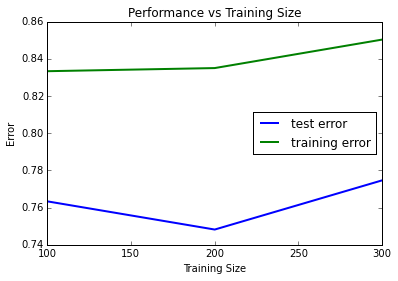

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_neighbors=7, p=2, weights='uniform')


In [129]:
print 'KNeighborsClassifier Model training'
# TODO: Choose a model, import it and instantiate an object
# Linear SVC .LinearSVC
#KN Neibers 
#SVC Ensable Classification 
# We will vary the training set size so that we have 50 different sizes
#start of copy 
from sklearn.metrics import f1_score
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=7)
    
sizes = np.linspace(len(X_train) / 3, len(X_train), 3)
train_err = np.zeros(len(sizes))
test_err = np.zeros(len(sizes))

for i, s in enumerate(sizes):
    s = s.astype(int)
   
    # Create and fit the decision tree regressor model
    clf.fit( X_train[:s], y_train[:s])
    train_predict(clf, X_train[:s], y_train[:s], X_test, y_test)
    # Find the performance on the training and testing set
    train_err[i] = f1_score  (y_train[:s], clf.predict(X_train[:s]) , pos_label='yes')
    test_err[i] = f1_score ( y_test, clf.predict(X_test) , pos_label='yes')


# Plot learning curve graph
learning_curve_graph(sizes, train_err, test_err)

# end of copy

# Fit model to training data
#train_classifier(clf, X_train, y_train)  # note: using entire training set here
print clf  # you can inspect the learned model by printing it

In [128]:
# Predict on training set and compute F1 score
from sklearn.metrics import f1_score

def predict_labels(clf, features, target):
    print "Predicting labels using {}...".format(clf.__class__.__name__)
    start = time.time()
    y_pred = clf.predict(features)
    end = time.time()
    print "Done!\nPrediction time (secs): {:.3f}".format(end - start)
    return f1_score(target.values, y_pred, pos_label='yes')

train_f1_score = predict_labels(clf, X_train, y_train)
print "F1 score for training set: {}".format(train_f1_score)

Predicting labels using KNeighborsClassifier...
Done!
Prediction time (secs): 0.007
F1 score for training set: 0.85032537961


In [101]:
# Train and predict using different training set sizes
def train_predict(clf, X_train, y_train, X_test, y_test):
    print "------------------------------------------"
    print "Training set size: {}".format(len(X_train))
    train_classifier(clf, X_train, y_train)
    print "F1 score for training set: {}".format(predict_labels(clf, X_train, y_train))
    print "F1 score for test set: {}".format(predict_labels(clf, X_test, y_test))

# TODO: Run the helper function above for desired subsets of training data
# Note: Keep the test set constant

## 5. Choosing the Best Model

- Based on the experiments you performed earlier, in 1-2 paragraphs explain to the board of supervisors what single model you chose as the best model. Which model is generally the most appropriate based on the available data, limited resources, cost, and performance?

###### Based on tests performed, I compared 3 models, Decision tree clasifier, Random forest, and Support Vector Classification. After evaluating performance of each model I choose Decision Tree Classifier Model for number of reasons:
###### - Accurancy: Model predicts with high F1 Score.  F1 score conveys the balance between the precision and the recall. 
###### - Peformance: Obtainings training and test prediction fastes

- In 1-2 paragraphs explain to the board of supervisors in layman's terms how the final model chosen is supposed to work (for example if you chose a Decision Tree or Support Vector Machine, how does it make a prediction).
###### Decision tree learning uses a decision tree as a predictive model which maps observations about an item to conclusions about the item's target value. It is called Classification trees because tree models predicts if the student drops out or not. 
<p>
- Fine-tune the model. Use Gridsearch with at least one important parameter tuned and with at least 3 settings. Use the entire training set for this.
<p>
<B> 
I have tuned each model to find best parmaeter. Please refer to outputs of each model </b>
<p>
- What is the model's final F<sub>1</sub> score?
<p>
<B>Best F1 score for test set is 0.802</B>

###  Student Intervention System - Decision Tree Classifier



<table cellpadding="0" cellspacing="0" class="c12">
   <tbody>
      <tr class="c10">
         <td class="c1 c9" colspan="1" rowspan="2">
            <p class="c0"><span class="c2"></span></p>
         </td>
         <td class="c9 c13" colspan="3" rowspan="1">
            <p class="c6"><span class="c2">Training set size</span></p>
         </td>
      </tr>
      <tr class="c10">
         <td class="c4 c9" colspan="1" rowspan="1">
            <p class="c6"><span class="c2">100</span></p>
         </td>
         <td class="c4 c9" colspan="1" rowspan="1">
            <p class="c6"><span class="c2">200</span></p>
         </td>
         <td class="c4 c9" colspan="1" rowspan="1">
            <p class="c6"><span class="c2">300</span></p>
         </td>
      </tr>
      <tr class="c11">
         <td class="c1" colspan="1" rowspan="1">
            <p class="c6"><span class="c2">Training time (secs)</span></p>
         </td>
         <td class="c4" colspan="1" rowspan="1">
            <p class="c0"><span class="c2">0</span></p>
         </td>
         <td class="c4" colspan="1" rowspan="1">
            <p class="c0"><span class="c2">0</span></p>
         </td>
         <td class="c4" colspan="1" rowspan="1">
            <p class="c0"><span class="c2">0</span></p>
         </td>
      </tr>
      <tr class="c11">
         <td class="c1" colspan="1" rowspan="1">
            <p class="c6"><span class="c2">Prediction time (secs)</span></p>
         </td>
         <td class="c4" colspan="1" rowspan="1">
            <p class="c0"><span class="c2">0</span></p>
         </td>
         <td class="c4" colspan="1" rowspan="1">
            <p class="c0"><span class="c2">0</span></p>
         </td>
         <td class="c4" colspan="1" rowspan="1">
            <p class="c0"><span class="c2">0</span></p>
         </td>
      </tr>
      <tr class="c11">
         <td class="c1" colspan="1" rowspan="1">
            <p class="c6"><span class="c2">F1 score for training set</span></p>
         </td>
         <td class="c4" colspan="1" rowspan="1">
            <p class="c0"><span class="c2">0.805</span></p>
         </td>
         <td class="c4" colspan="1" rowspan="1">
            <p class="c0"><span class="c2">0.812</span></p>
         </td>
         <td class="c4" colspan="1" rowspan="1">
            <p class="c0"><span class="c2">0.813</span></p>
         </td>
      </tr>
      <tr class="c11">
         <td class="c1" colspan="1" rowspan="1">
            <p class="c6"><span class="c2">F1 score for test set</span></p>
         </td>
         <td class="c4" colspan="1" rowspan="1">
            <p class="c0"><span class="c2">0.802</span></p>
         </td>
         <td class="c4" colspan="1" rowspan="1">
            <p class="c0"><span class="c2">0.802</span></p>
         </td>
         <td class="c4" colspan="1" rowspan="1">
            <p class="c0"><span class="c2">0.802</span></p>
         </td>
      </tr>
   </tbody>
</table>

###  Student Intervention System - LinearSVC Classifier



<table cellpadding="0" cellspacing="0" class="c12">
   <tbody>
      <tr class="c10">
         <td class="c1 c9" colspan="1" rowspan="2">
            <p class="c0"><span class="c2"></span></p>
         </td>
         <td class="c9 c13" colspan="3" rowspan="1">
            <p class="c6"><span class="c2">Training set size</span></p>
         </td>
      </tr>
      <tr class="c10">
         <td class="c4 c9" colspan="1" rowspan="1">
            <p class="c6"><span class="c2">100</span></p>
         </td>
         <td class="c4 c9" colspan="1" rowspan="1">
            <p class="c6"><span class="c2">200</span></p>
         </td>
         <td class="c4 c9" colspan="1" rowspan="1">
            <p class="c6"><span class="c2">300</span></p>
         </td>
      </tr>
      <tr class="c11">
         <td class="c1" colspan="1" rowspan="1">
            <p class="c6"><span class="c2">Training time (secs)</span></p>
         </td>
         <td class="c4" colspan="1" rowspan="1">
            <p class="c0"><span class="c2">0.007</span></p>
         </td>
         <td class="c4" colspan="1" rowspan="1">
            <p class="c0"><span class="c2">0.018</span></p>
         </td>
         <td class="c4" colspan="1" rowspan="1">
            <p class="c0"><span class="c2">0.024</span></p>
         </td>
      </tr>
      <tr class="c11">
         <td class="c1" colspan="1" rowspan="1">
            <p class="c6"><span class="c2">Prediction time (secs)</span></p>
         </td>
         <td class="c4" colspan="1" rowspan="1">
            <p class="c0"><span class="c2">0</span></p>
         </td>
         <td class="c4" colspan="1" rowspan="1">
            <p class="c0"><span class="c2">0</span></p>
         </td>
         <td class="c4" colspan="1" rowspan="1">
            <p class="c0"><span class="c2">0</span></p>
         </td>
      </tr>
      <tr class="c11">
         <td class="c1" colspan="1" rowspan="1">
            <p class="c6"><span class="c2">F1 score for training set</span></p>
         </td>
         <td class="c4" colspan="1" rowspan="1">
            <p class="c0"><span class="c2">0.874</span></p>
         </td>
         <td class="c4" colspan="1" rowspan="1">
            <p class="c0"><span class="c2">0.825</span></p>
         </td>
         <td class="c4" colspan="1" rowspan="1">
            <p class="c0"><span class="c2">0.841</span></p>
         </td>
      </tr>
      <tr class="c11">
         <td class="c1" colspan="1" rowspan="1">
            <p class="c6"><span class="c2">F1 score for test set</span></p>
         </td>
         <td class="c4" colspan="1" rowspan="1">
            <p class="c0"><span class="c2">0.724</span></p>
         </td>
         <td class="c4" colspan="1" rowspan="1">
            <p class="c0"><span class="c2">0.782</span></p>
         </td>
         <td class="c4" colspan="1" rowspan="1">
            <p class="c0"><span class="c2">0.796</span></p>
         </td>
      </tr>
   </tbody>
</table>

###  Student Intervention System - KNeighborsClassifier Classifier



<table cellpadding="0" cellspacing="0" class="c12">
   <tbody>
      <tr class="c10">
         <td class="c1 c9" colspan="1" rowspan="2">
            <p class="c0"><span class="c2"></span></p>
         </td>
         <td class="c9 c13" colspan="3" rowspan="1">
            <p class="c6"><span class="c2">Training set size</span></p>
         </td>
      </tr>
      <tr class="c10">
         <td class="c4 c9" colspan="1" rowspan="1">
            <p class="c6"><span class="c2">100</span></p>
         </td>
         <td class="c4 c9" colspan="1" rowspan="1">
            <p class="c6"><span class="c2">200</span></p>
         </td>
         <td class="c4 c9" colspan="1" rowspan="1">
            <p class="c6"><span class="c2">300</span></p>
         </td>
      </tr>
      <tr class="c11">
         <td class="c1" colspan="1" rowspan="1">
            <p class="c6"><span class="c2">Training time (secs)</span></p>
         </td>
         <td class="c4" colspan="1" rowspan="1">
            <p class="c0"><span class="c2">0.001</span></p>
         </td>
         <td class="c4" colspan="1" rowspan="1">
            <p class="c0"><span class="c2">0.001</span></p>
         </td>
         <td class="c4" colspan="1" rowspan="1">
            <p class="c0"><span class="c2">0.001</span></p>
         </td>
      </tr>
      <tr class="c11">
         <td class="c1" colspan="1" rowspan="1">
            <p class="c6"><span class="c2">Prediction time (secs)</span></p>
         </td>
         <td class="c4" colspan="1" rowspan="1">
            <p class="c0"><span class="c2">0.002</span></p>
         </td>
         <td class="c4" colspan="1" rowspan="1">
            <p class="c0"><span class="c2">0.002</span></p>
         </td>
         <td class="c4" colspan="1" rowspan="1">
            <p class="c0"><span class="c2">0.006</span></p>
         </td>
      </tr>
      <tr class="c11">
         <td class="c1" colspan="1" rowspan="1">
            <p class="c6"><span class="c2">F1 score for training set</span></p>
         </td>
         <td class="c4" colspan="1" rowspan="1">
            <p class="c0"><span class="c2">0.833</span></p>
         </td>
         <td class="c4" colspan="1" rowspan="1">
            <p class="c0"><span class="c2">0.835</span></p>
         </td>
         <td class="c4" colspan="1" rowspan="1">
            <p class="c0"><span class="c2">0.748</span></p>
         </td>
      </tr>
      <tr class="c11">
         <td class="c1" colspan="1" rowspan="1">
            <p class="c6"><span class="c2">F1 score for test set</span></p>
         </td>
         <td class="c4" colspan="1" rowspan="1">
            <p class="c0"><span class="c2">0.763</span></p>
         </td>
         <td class="c4" colspan="1" rowspan="1">
            <p class="c0"><span class="c2">0.782</span></p>
         </td>
         <td class="c4" colspan="1" rowspan="1">
            <p class="c0"><span class="c2">0.774</span></p>
         </td>
      </tr>
   </tbody>
</table>